In [1]:
import sys
sys.path.append("../")

import sim_net

import itertools, pickle, PIL.Image
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

In [2]:
kingfisher = "/Users/James/Documents/PSY6431/data/images/kingfisher-1905255_640.jpg" # KINGFISHER

---

#### CROP IMAGE

In [3]:
def crop_img(img, size, offset):
    img = np.array(img)

    x = img.shape[1]
    y = img.shape[0]
    
    x1 = int((x - size[0] + offset[0])/2)
    x2 = int((x + size[0] + offset[0])/2)
    y1 = int((y - size[1] + offset[1])/2)
    y2 = int((y + size[1] + offset[1])/2)

    return PIL.Image.fromarray(img[y1:y2,x1:x2])

In [4]:
img = PIL.Image.open(kingfisher)

img_cropped = crop_img(img, (200,200), (130,40))
# img_cropped.save("cropped.jpg")

img_resized = img.resize((35,35), resample=PIL.Image.BILINEAR)
# img_resized.save("resized.jpg")

---

#### CREATE NETWORK FROM IMAGE (Resized)

Nnode= 1225 Nedge= 37010


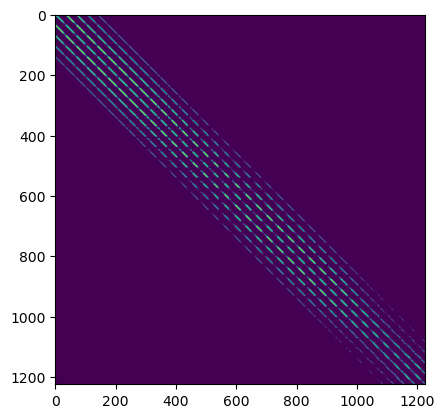

In [5]:
img = np.array(img_resized, dtype=float) / np.max(img) # Normalised input matrix

# Adjacency matrix
n_row = img.shape[0]
n_col = img.shape[1]
N = n_row * n_col

sigmaI = 0.1
sigmaX = 4.0
r = 5

tmp = itertools.product(range(n_row), range(n_col))
combi_all = itertools.combinations(tmp, 2)
combi = [x for x in combi_all if np.sqrt((x[0][0] - x[1][0])**2 + (x[0][1] - x[1][1])**2) < r]

edgelist_w = []
for x1,x2 in combi:
    n1 = int(x1[0] * n_col + x1[1])
    n2 = int(x2[0] * n_col + x2[1])
    simval = np.exp(-np.sum((img[x1[0], x1[1]] - img[x2[0], x2[1]])**2) / (sigmaI**2)) * np.exp(-((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2) / (sigmaX**2))
    edgelist_w.append((n1, n2, simval))

#Adjacency matrix
W = np.zeros([N, N])
for x in edgelist_w:
    W[x[0],x[1]] = x[2]
    W[x[1],x[0]] = x[2]

print("Nnode=", N, "Nedge=", len(edgelist_w))
plt.imshow(W)

#numpy.savetxt("edgelist_weight.csv", edgelist_w, delimiter=",")
# np.savetxt("adjacency.csv", W, delimiter=",")

---

#### GRAPH LAPLACIAN

In [6]:
P = W.shape[0] # Adjacency Matrix

Dnorm = np.diag(np.sum(W,axis=1)**-1) # Normalize

# Laplacian
L = np.eye(P) - Dnorm @ W
e, v = scipy.linalg.eig(L)

# Eigenval
e = np.real(e)
v = np.real(v)

order = np.argsort(e)
e = e[order]
v = v[:,order]

# np.savetxt("eigenval.csv", e, delimiter=",")
# np.savetxt("eigenvec.csv", v, delimiter=",")

---

#### SIM IMAGE

In [7]:
figsize = np.array(img_resized).shape[:2]
normalize = "asym" # Mode

# Network simulation
N = 30000
prob = 0.1
eta = 0.01
simlen = 3000
gamma = 0.6
a_arr = np.arange(-1.5,3.1,0.1)

start_node = int(int(figsize[0]/2) * figsize[1] + int(figsize[1]/2))

a_hist = []
m_hist = []
obj_hist = np.zeros([len(a_arr),simlen])

In [8]:
network = sim_net.sim_net(N, P, prob, W, gamma, normalize)

In [9]:
for a_ind in range(len(a_arr)):
    a=np.around(a_arr[a_ind],decimals=1)
    print(a, a_ind)
    m_log,obj_log = network.simulate_single(a,eta,simlen,start_node)
    m=m_log[-1,:]

    a_hist.append(a)
    m_hist.append(m)
    save=(a_hist,m_hist)
    pickle.dump(save, open("results.pickle","wb"))

    obj_hist[a_ind,:]=obj_log
    break
    # np.savetxt("objfunc.csv", obj_hist, delimiter=",")

-1.5 0
0
100
200
300
